In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [3]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
cluster = LocalCluster(n_workers=1, dashboard_address="localhost:32769")
client = Client(cluster)

/home/yuxlong5/miniconda3/envs/equinox/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 32769 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44317 instead
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44317/status,
Dashboard: http://127.0.0.1:44317/status,Workers: 1
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41887,Workers: 1
Dashboard: http://127.0.0.1:44317/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:42903,Total threads: 128
Dashboard: http://127.0.0.1:35849/status,Memory: 251.08 GiB
Nanny: tcp://127.0.0.1:36257,


# KPPhbl - Surface bounday layer?

In [6]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/meddy/yuxlong5/data/LLC4320/KPPhbl/'
# the path where the data will be re-stored
out_dir_nc = '/meddy/yuxlong5/data/data_store/'

# variable 
v = 'KPPhbl'

In [8]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+'/'+v+'_177x201.*')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):
#for i in np.arange(20):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        ds = np.fromfile(filenames[i] , dtype='>f').reshape(201,177)
        ds = np.array(ds)
        ds = xr.DataArray(ds, dims=['lat','lon'])
        ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors

        #
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))

Number of files processed: 9415


# 2. Add coordinates and put variables into one xarray file

In [10]:
filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))

Number of files processed: 9415


In [13]:
%time ds = xr.open_mfdataset(filenames, concat_dim="time",combine="nested")
print(ds)

CPU times: user 13.2 s, sys: 1.19 s, total: 14.4 s
Wall time: 13.8 s
<xarray.Dataset> Size: 1GB
Dimensions:  (time: 9415, lat: 201, lon: 177)
Dimensions without coordinates: time, lat, lon
Data variables:
    KPPhbl   (time, lat, lon) float32 1GB dask.array<chunksize=(1, 201, 177), meta=np.ndarray>


In [14]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [15]:
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
print(ds)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 9415, lat: 201, lon: 177)
Coordinates:
  * time     (time) float64 75kB 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    KPPhbl   (time, lat, lon) float32 1GB dask.array<chunksize=(1, 201, 177), meta=np.ndarray>


In [16]:
chunks = {'time': 9415, 'lat': 201, 'lon': 177}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 9415, lat: 201, lon: 177)
Coordinates:
  * time     (time) float64 75kB 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    KPPhbl   (time, lat, lon) float32 1GB dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>


In [17]:
out_dir_zarr = '/meddy/yuxlong5/data/data_zarr/'

file_out = out_dir_zarr+'/%s_total_rechunk.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     

/home/yuxlong5/miniconda3/envs/equinox/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 11.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 8.96 s, sys: 434 ms, total: 9.4 s
Wall time: 13.3 s


# Read re-chunked data

In [18]:
ds = xr.open_zarr(out_dir_zarr+v+'_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 9415, lat: 201, lon: 177)
Coordinates:
  * time     (time) float64 75kB 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    KPPhbl   (time, lat, lon) float32 1GB dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

 data size: 1.3 GB


CPU times: user 86.6 ms, sys: 31.5 ms, total: 118 ms
Wall time: 1.04 s


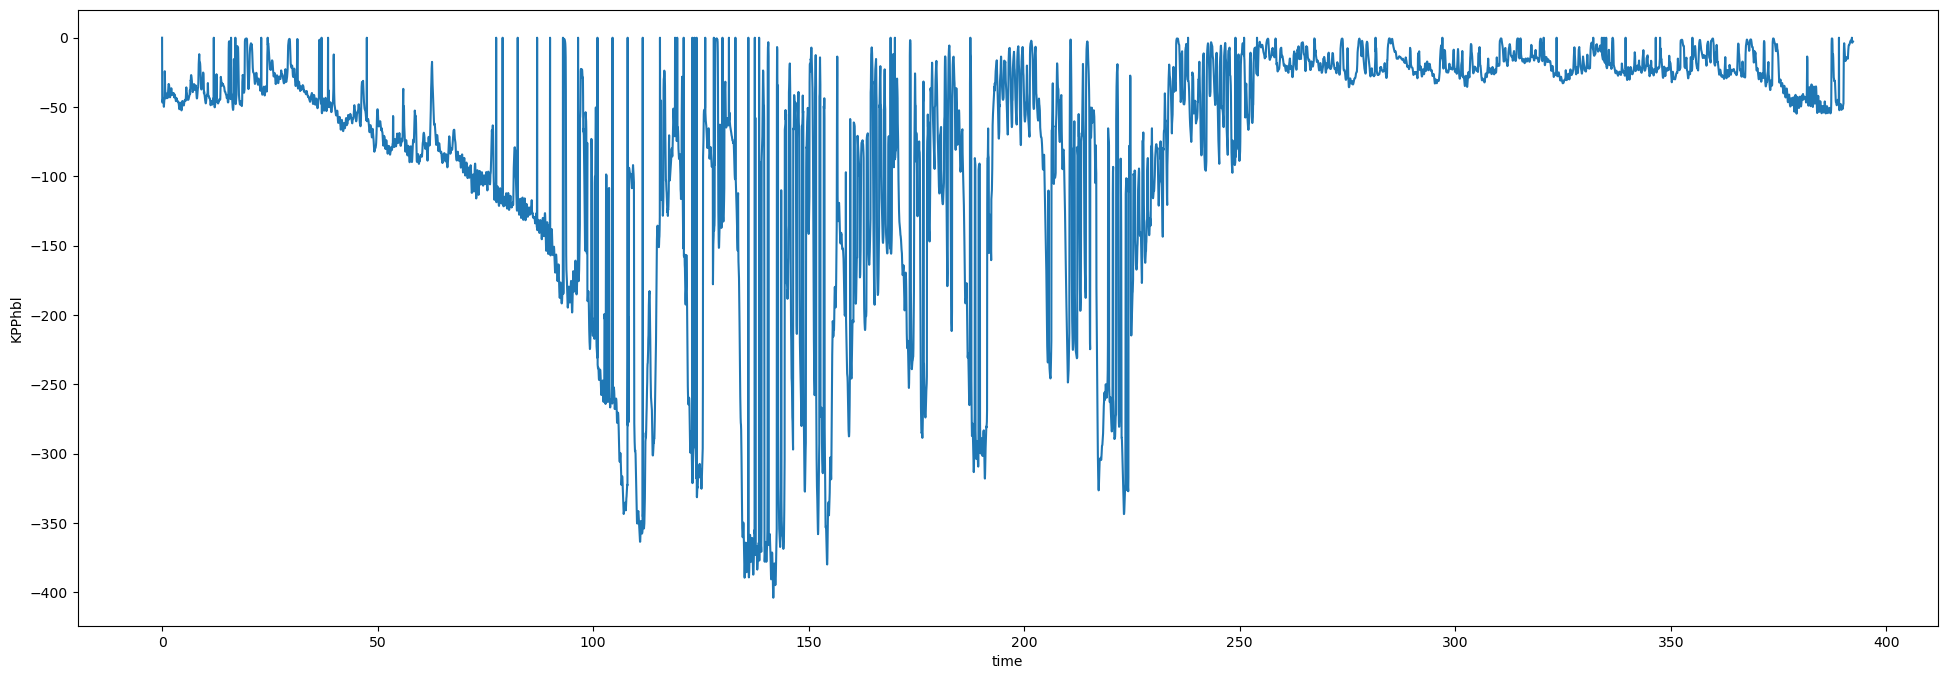

In [19]:
fig = plt.figure(figsize=(24,8))
%time (-1*ds[v]).isel(lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

In [9]:
client.dashboard_link

'http://127.0.0.1:8787/status'

In [10]:
cluster.scheduler.close()

<coroutine object Scheduler.close at 0x7f9384125c40>